In [281]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required
%pip install scikit-learn
%pip install pandas
%pip install matplotlib
%pip install tensorflow


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [282]:
import sklearn
import skfuzzy


In [283]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from sklearn.preprocessing import MinMaxScaler


In [284]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

1. Data Analysis and Bayes Nets

In [306]:
# creating a numpy array from a npy file

arrayX = np.load("smiley_noisy_X.npy")
arrayY = np.load("smiley_noisy_Y.npy")


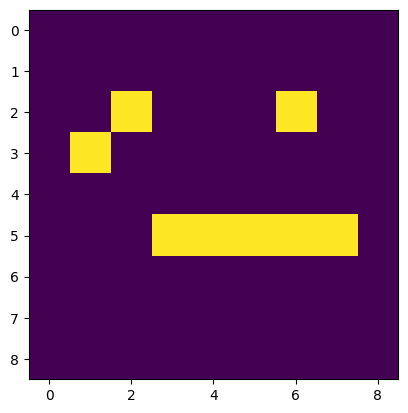

In [304]:
# showing the images the faces create based on each element in the array
plt.imshow(arrayX[100])
plt.show()


In [287]:
print(arrayY[100])

1.0


In [288]:
#so each pixel is considered a single data point making visualisation easier 
flattened = arrayX.flatten()
print(flattened[500])

0.0


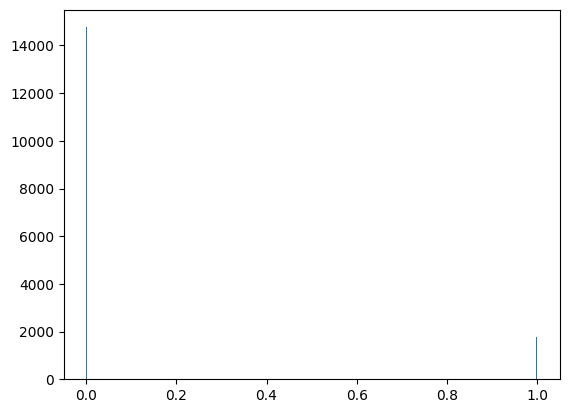

In [289]:
#makes sure all the values are 0 and 1 
plt.hist(flattened, bins=500)
plt.show()

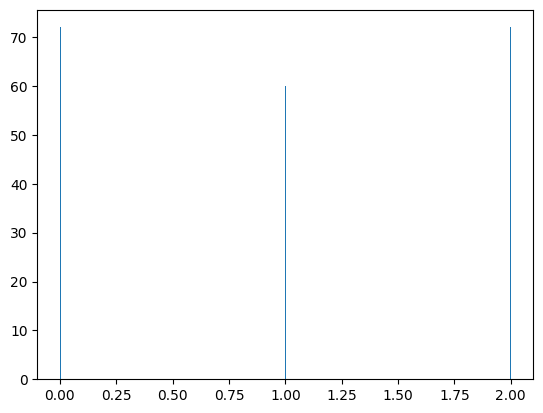

In [30]:
# This will be important later as some of the classification algos are sensitive to imbalanced datasets
plt.hist(arrayY, bins=500)
plt.show()

In [31]:
#to find the mean number of 1s/pixels in the image dataset just so we know whats is going on
noOfOnes = []
for one in arrayX:
    ones_count = np.count_nonzero(one == 1)
    noOfOnes.append(ones_count)
overall_mean = np.mean(noOfOnes)
print("Mean number of pixels: ",overall_mean)


Mean number of pixels:  8.686274509803921


In [305]:
from sklearn.decomposition import PCA
# reduces the dimensionality from 4 to 2 so it can be used to train and test the dataset
a = arrayX.reshape(204,-1)
# keeps 95% of the variablity in the dataset while reducing the noise in the dataset
Pc = PCA(n_components=0.90, random_state=2020)
x = Pc.fit_transform(a)
print(x.shape)

(204, 13)


PCA is used to reduce the dimensionality and keep the significant parts of the dataset and while there is still noise from looking at my algorithms performance throughout its clear that despite the noise there still able to capture the appropiate information as they have high accuracys with both seen and unseen data. Using spicy.ndimage and its various denoising techniques i wasnt able to figure out how to denoise my dataset as a result i belive that throughout there is a possibility that quite a few of my algorithms are training with the noise in this dataset and as a result it may not generalize well to another real world dataset. Luckily i also have the non noisy dataset that i can use throughout to evaluate this one and what i found via a few quick tests with K-means, agglomerative clustering, logistic regression and naive bayes is i still got a high accuracy and thier other associated scores usually at around 80% but this means that the noise present in the noisy dataset isnt too affecting when trying to discover the underlaying patterns. The only difference i found is that when using PCA to keep 90% of the variance the noisy dataset kept 13 dimensions while the non noisy datset kept only 12 that extra dimension will be due to the noise and its removal would likely help my algorithms achieve even better results. I will maintain the 13 dimensions as the non noisy dataset isnt perfect in terms of having no artefacts

In [317]:
# splitting the dataset so that a classifier can be trained using it 
# FGor the future while processing we will maintain these reduction in dimensionality as it results in less complexity when processing the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,arrayY,test_size=0.2,random_state=42)
print(arrayX.shape)

(204, 9, 9, 1)


In [318]:
#naive bayes classifier and training the classifier
from sklearn.naive_bayes import GaussianNB
NaiveBayes = GaussianNB()
bat = NaiveBayes.fit(X_train, y_train)
predicted = NaiveBayes.predict(X_test)
print(bat)


GaussianNB()


accuracy:  0.926829268292683
F1 Score:  0.9279279279279279


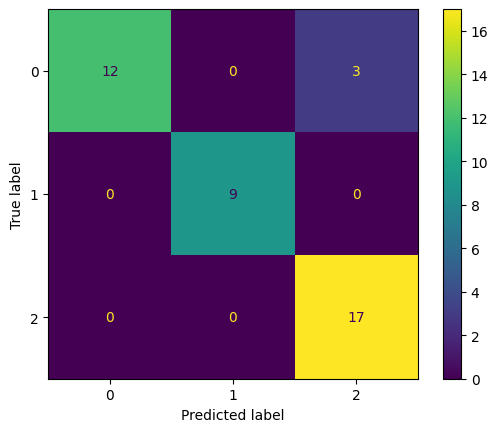

In [319]:
#https://www.datacamp.com/tutorial/naive-bayes-scikit-learn
#running naive bayes on unseen data and providing the evaluation metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, roc_auc_score,roc_curve, classification_report,mean_squared_error,f1_score,recall_score,precision_score
accuracy = accuracy_score(predicted, y_test)
f1 = f1_score(predicted, y_test, average="weighted")
# To label the confusion matrix
labels = [0,1,2]
confusion = confusion_matrix(y_test,predicted, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=labels)
disp.plot()

print("accuracy: ",accuracy)
print("F1 Score: ", f1)



In [323]:
# Using recursive feature elimination to find the features that most contribute to the target attribute
# RFE also uses greedy search to find the best features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# Uses logistic regression to determine the best features. Keep the implementation here seperate as it can cause overfitting as it trains on the whole dataset
model1 = LogisticRegression()
rfer = RFE(estimator=model1, n_features_to_select=3)
selected_indices = []
selected = []

# Only trains the algorithim based on the class 0,1,2 with the assocated faces
for i in range(3):
    fit = rfer.fit_transform(x,(arrayY==i))
    selected_indices.append(np.where(rfer.support_)[0])
    selected.append(fit)
merged = np.concatenate(selected, axis=1)
print("Selected feature indices for each class:")
for i, indices in enumerate(selected_indices):
    print(f"Class {i}: {indices}")

Selected feature indices for each class:
Class 0: [2 5 6]
Class 1: [ 7  8 11]
Class 2: [ 5  6 11]


In [325]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(merged,arrayY,test_size=0.2,random_state=42)

accuracy:  0.926829268292683
F1 Score:  0.9279279279279279


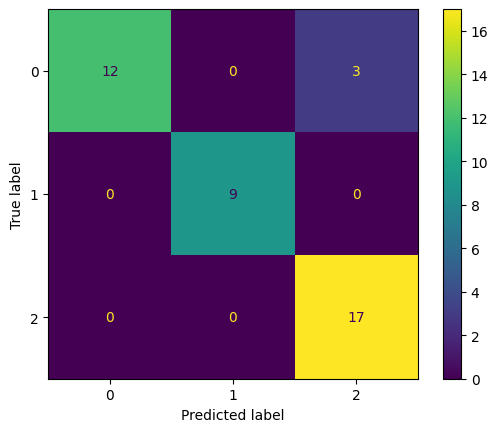

In [326]:
# Using Naive Bayes to see how the features can affect evaluation metrics 
from sklearn.naive_bayes import GaussianNB
NaiveBayes1 = GaussianNB()
NaiveBayes1.fit(X_train2,y_train2)
predicted = NaiveBayes1.predict(X_test2)
#Finding the accuracy on unseen data 
accuracy = accuracy_score(predicted, y_test2)
f1 = f1_score(predicted, y_test2, average="weighted")
labels = [0,1,2]
confusion = confusion_matrix(y_test2,predicted, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=labels)
disp.plot()
# When using the 3 top features to make up another dataset i get the same accuracy as the original dataset. This may suggest a further dimensionality reduction from 13 to 9 may not have an adverse efffect on the dataset 
# In fact the confusion matrix is the exact same as the original dataset which means that the features missing after RFE may not be significant alone
# Though the classes are not represented equally because 0 and 1 are perfectly predicted compared to 2 which is still missclassified
# When using the 6 top features i got a perfect accuracy. this is likely due to the repeated features in the dataset causing overfitting as the classifier begins to learn a complex pattern that only really works with this data 
print("accuracy: ",accuracy)
print("F1 Score: ", f1)

When looking at the top 3 features that correlate the most per class there are a few that repeat for 2 classes but none that repeat over all 3. This suggests that there is some distinction between the three that is represented even with the dimensionality of the overall dataset reduced. When using a combination of these features with some repition amoung the features for 3 features for each of the 3 classess we get the same accuracy as the original dataset suggesting these features are all that are neccesary for algorithms predicting class whereas when using 6 of the top features for each you get a perfect score for all metrics which is likely due to overfitting from naive bayes learning the patterns in the dataset too well. The features that were not important from my tests were 0,1,3,4,9,10,12 but they will still be included in the other algorithms as these features may still help to provide variability and distinction between the 3 classes 

2. Clustering

K - means clustering - Hard clustering

In [44]:
# associates the most probable label(happy,sad,neutral) with each cluster 
def retrieve(label, y_train):
    reference_labels = {}
    #for loop to run through each label
    for i in range(len(np.unique(label))):
        # assigns a 1 to to cluster labels associated with i and 0 to those that are not
        index = np.where(label == i,1,0)
        # finds the label with the highest count for the cluster
        num = np.bincount(y_train[index == 1]).argmax()
        # The cluster i acts as a key and the most probable true label is assigned to it
        reference_labels[i] = num
    return reference_labels

In [45]:
y_train = y_train.astype(int)

In [166]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score

# Initialize a list to store evaluation metrics
accuracy_scores = []
Rand_index = []
silhouette_scores = []
# K means clustering is used hard clustering coverges to a local minimum not a global 
# dont want the number of clusters to be too high to prevent overfitting

for i in range(25):
    k = i + 2
    kmeans = KMeans(n_clusters=k, random_state=20)
    y_kmeans = kmeans.fit_predict(X_train)

   # This then assigns the most probable label to each data point so we can use the accuracy score metric
# https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47#:~:text=Yes!,Here%27s%20how.&text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.
    reference_labels = retrieve(y_kmeans, y_train)
    for j in range(len(y_kmeans)):
        numbe_lab[j] = reference_labels[y_kmeans[j]]

    # Calculates the evaluation metrics
    score = accuracy_score(numbe_lab, y_train)
    accuracy_scores.append(score)
    rand = adjusted_rand_score(numbe_lab, y_train)
    Rand_index.append(rand)
    silhouette = silhouette_score(X_train, y_kmeans)
    silhouette_scores.append(silhouette)

# Prints accuracy scores and adjusted rand index using zip allows me to iterate over both
for k, (score, rand, silhouette) in enumerate(zip(accuracy_scores,Rand_index,silhouette_scores), start=3):
    print(f"Number of clusters: {k}, Accuracy score: {score}, Rand index: {rand}, Silhouette score:{silhouette}")
# we have the true labels to evaluate our clustering
#adjusted rand index is a simirality measure between the clustering labels and adjusts for chance
# measures how well the kmeans clustering does compared to the real clustering of the images 
# https://oecd.ai/en/catalogue/metrics/adjusted-rand-index-%28ari%29

Number of clusters: 3, Accuracy score: 0.6503067484662577, Rand index: 0.36922091708053467, Silhouette score:0.2115167416831368
Number of clusters: 4, Accuracy score: 0.6625766871165644, Rand index: 0.3426741232821378, Silhouette score:0.26533965516997665
Number of clusters: 5, Accuracy score: 0.6625766871165644, Rand index: 0.3426741232821378, Silhouette score:0.3091751786138826
Number of clusters: 6, Accuracy score: 0.7361963190184049, Rand index: 0.3498122175688358, Silhouette score:0.3185683163242803
Number of clusters: 7, Accuracy score: 0.8282208588957055, Rand index: 0.5354426578580983, Silhouette score:0.3221721347608679
Number of clusters: 8, Accuracy score: 0.7361963190184049, Rand index: 0.3801356841935824, Silhouette score:0.32378649678070753
Number of clusters: 9, Accuracy score: 0.8282208588957055, Rand index: 0.5354426578580983, Silhouette score:0.3414611242424903
Number of clusters: 10, Accuracy score: 0.8282208588957055, Rand index: 0.5354426578580983, Silhouette score

In [292]:
y_test = y_test.astype(int)
k = 18
kmeans = KMeans(n_clusters=k, random_state=20)
y_kmeans = kmeans.fit_predict(X_test)

   # This then assigns the most probable label to each data point so we can use the accuracy score metric
# https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47#:~:text=Yes!,Here%27s%20how.&text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.
reference_labels = retrieve(y_kmeans, y_test)
numbe_lab = np.random.rand(len(y_kmeans))
for j in range(len(y_kmeans)):
    numbe_lab[j] = reference_labels[y_kmeans[j]]

# Calculates the accuracy score
score = accuracy_score(numbe_lab, y_test)
rand = adjusted_rand_score(numbe_lab, y_test)
print(score, rand)
# High results for training and testing data suggesting that overfitting is not occuring
# Result is slightly lower than the naive bayes classification. The greatest flaw when compared to naive bayes is that to evaluate accuracy the clusters are assigned labels based on what the majority of the cluster so a sad face could be in a label that is deigned as neutral
# That being said it still works to give high accuracy and a rand score so we can say this method is succesful

0.926829268292683 0.8107439122290607


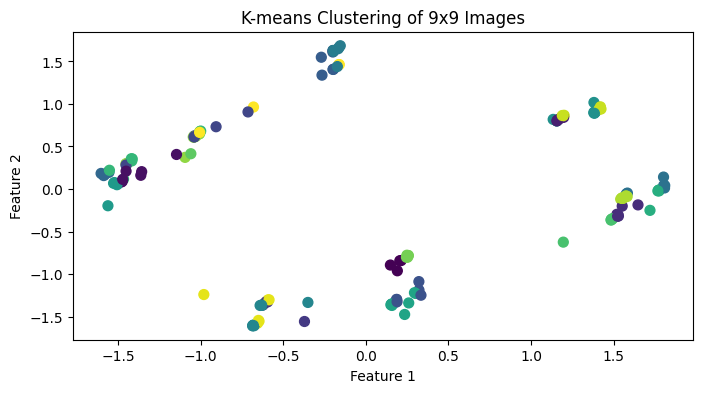

In [114]:
# Visualize clusters
plt.figure(figsize=(8, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_kmeans, s=50, cmap='viridis')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-means Clustering of 9x9 Images")
plt.show()
# Shows our dataset is very linear

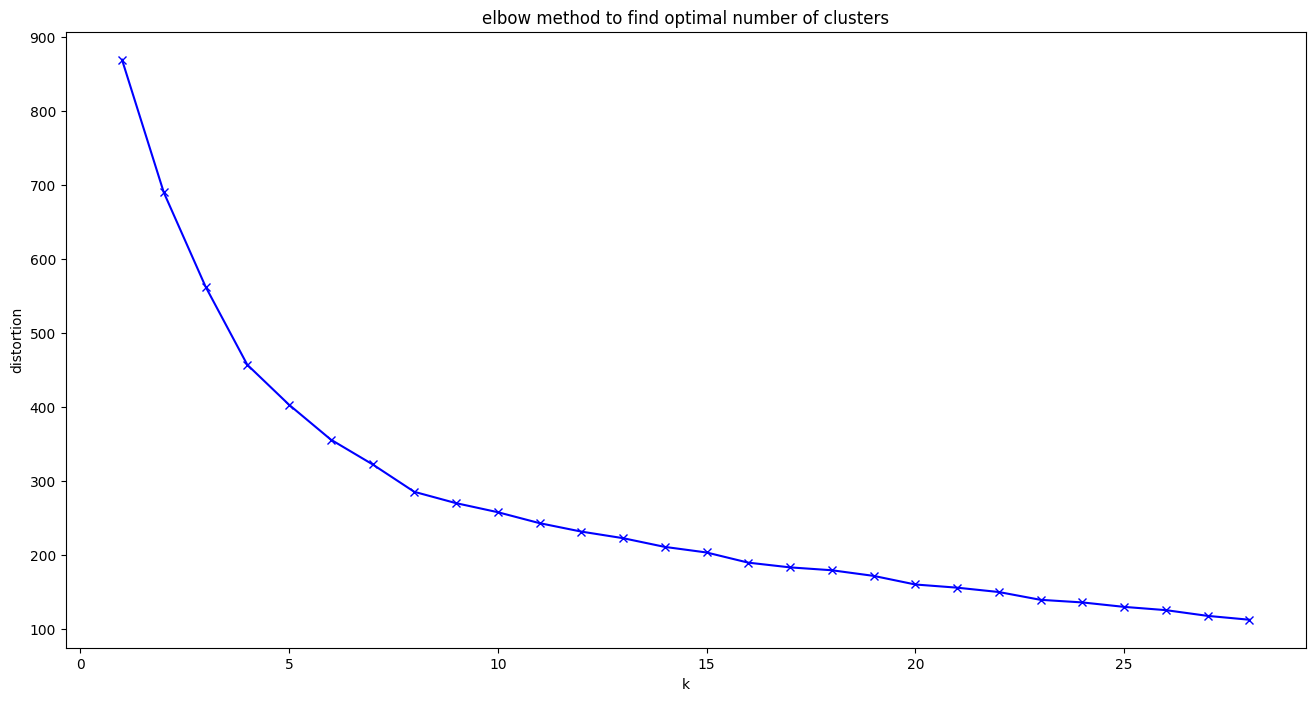

In [105]:
# Elbow method for k means clustering
#https://predictivehacks.com/k-means-elbow-method-code-for-python/
import warnings
warnings.filterwarnings("ignore")
distortions = []
K = range(1,29)
for k in K:
    KMEANS = KMeans(n_clusters=k, random_state=20)
    KMEANS.fit(X_train)
    #Measures how well a dataset is clustered but we also want the lowest number of clusters as possible
    #Inertia usually decreases along with the number of clusters
    distortions.append(KMEANS.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('elbow method to find optimal number of clusters')
plt.show()
# This would be incredibly useful if we did not have the real labels
# But as shown above its unrealible when using it to come up with the best number of clusters 

The elbow here is when the nuber of clusters = 8 when looking at how accurate the cluster is when its 8 the figure is still acceptable so by that metric we can say that the elbow method is useful if we were using this unsupervised algorithm without the true labels.
Also we get a high accuracy and adjusted rand index however the silhouette score remains low, i dont think the low silhouette score is significant enough to revaluate the clusters especially as the accuracy and adjusted rand index stay high even when tested on unseen data. The conclusion we can come to from this is that there is some natural overlap of clusters here. Also with a silhouette score of 0.3 the clusters are still somewhat distinct anyway.

In [50]:
# Hierachical clustering - A method of hard clustering

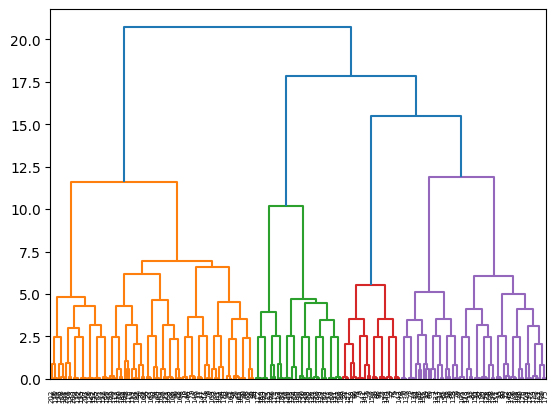

In [51]:
# Considers each image as its own cluster then slowly groups them up based on how similar they are
#Simirality is based on using eucledian distances
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
# links each image to its real classification
tree = hierarchy.dendrogram(hierarchy.linkage(x, method='ward'))
# Use this tree so that i can choose the optimal number of clusters
# If i didnt already have the true labels i would still choose 3

In [52]:
m = 0 + 1
hierachical_cluster = AgglomerativeClustering(n_clusters = m, affinity='euclidean', linkage='ward')
hierachical_label = hierachical_cluster.fit_predict(X_train)
hierachical_label = hierachical_label.astype(int)
print(hierachical_label)
print(y_train)
# Here there are empty cluster because unlike k means where each data point is assigned to a cluster in hierarchical clustering these data points start as there own clusters and are then grouped together

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 2 0 2 1 2 2 2 0 0 2 0 1 2 1 1 1 2 1 0 1 2 0 2 0 0 1 1 0 0 1
 2 1 0 2 2 0 0 2 2 2 1 1 0 2 1 0 1 2 0 1 2 1 0 2 1 1 2 1 2 2 0 0 0 1 2 0 2
 2 0 0 0 2 1 1 1 0 2 0 2 1 2 2 2 2 1 1 0 1 0 1 2 2 1 0 0 0 1 0 0 2 1 2 1 2
 2 0 0 2 2 2 0 1 0 2 2 0 0 1 0 0 0 1 0 0 1 0 0 2 2 0 1 0 0 1 2 0 2 0 2 0 2
 1 1 0 2 2 0 0 2 0 2 1 2 1 1 1]


In [172]:
accuracy_scores = []
Rand_index = []
silhouette_scores = []
# I want to run through a number of clusters to get the rand score and accuracy for hard clustering
for i in range(80):
    m = i + 2
    h_cluster = AgglomerativeClustering(n_clusters = m)
    h_label = h_cluster.fit_predict(X_train)

    
    # Assigns the most probable label to the data point
    h_label = h_label.astype(int)
    ref_lab = retrieve(h_label, y_train)
    number_labels = np.empty(len(h_label))
    for j in range(len(h_label)):
        if h_label[j] in ref_lab:
            number_labels[j] = ref_lab[h_label[j]]
        else:
            number_labels[j] = -1 # Default label for empty clusters

    # Calculates the evaluation metrics 
    score = accuracy_score(number_labels, y_train)
    accuracy_scores.append(score)
    rand = adjusted_rand_score(number_labels, y_train)
    Rand_index.append(rand)
    silhouette = silhouette_score(X_train, h_label)
    silhouette_scores.append(silhouette)
    # Prints accuracy scores and adjusted rand index using zip allows me to iterate over both
for k, (score, rand,silhouette) in enumerate(zip(accuracy_scores,Rand_index, silhouette_scores), start=2):
    print(f"Number of clusters: {k}, Accuracy score: {score}, adjusted rand index: {rand}, silhouette scores:{silhouette}")


Number of clusters: 2, Accuracy score: 0.6503067484662577, adjusted rand index: 0.36922091708053467, silhouette scores:0.2115167416831368
Number of clusters: 3, Accuracy score: 0.6625766871165644, adjusted rand index: 0.3426741232821378, silhouette scores:0.26533965516997665
Number of clusters: 4, Accuracy score: 0.6625766871165644, adjusted rand index: 0.3426741232821378, silhouette scores:0.3091751786138826
Number of clusters: 5, Accuracy score: 0.7361963190184049, adjusted rand index: 0.3498122175688358, silhouette scores:0.3185683163242803
Number of clusters: 6, Accuracy score: 0.8282208588957055, adjusted rand index: 0.5354426578580983, silhouette scores:0.3221721347608679
Number of clusters: 7, Accuracy score: 0.8282208588957055, adjusted rand index: 0.5354426578580983, silhouette scores:0.34651223934835046
Number of clusters: 8, Accuracy score: 0.8282208588957055, adjusted rand index: 0.5354426578580983, silhouette scores:0.3292735763048519
Number of clusters: 9, Accuracy score:

The biggest issue with hierachical clustering is how easily overfitting can occur as each data point starts as its own cluster it is easy to get perfect scores for accuracy score and adjusted rand index even when compared to K-means. This is why silhouette score is so important here with the highest being at the number of clusters being 65 but the accuracy score and adjusted rand index are both at 0.99 however this at least shows that the clusters here are distinct with meaningful partitions

In [293]:
h_cluster = AgglomerativeClustering(n_clusters = 16)
h_label = h_cluster.fit_predict(X_test)

    
# Assigns the most probable label to the data point
h_label = h_label.astype(int)
ref_lab = retrieve(h_label, y_test)
number_labels = np.empty(len(h_label))
for j in range(len(h_label)):
    if h_label[j] in ref_lab:
        number_labels[j] = ref_lab[h_label[j]]
    else:
        number_labels[j] = -1 # Default label for empty clusters

# Calculates the evaluation metrics 
score = accuracy_score(number_labels, y_test)
rand = adjusted_rand_score(number_labels, y_test)
silhouette = silhouette_score(X_test, h_label)
print(score, rand,silhouette)

0.9024390243902439 0.7575513221113463 0.43097074554196474


When applying the algorithim to unseen data and using proportional clustering due to the size of the test data. We get significant differences however the accuracy is still high and the adjusted rand index is still high so we can say it generalizes well to new data. Of course until its used in a full real world example with a completely new dataset we cannot say for sure for any machine learning algorithm.

Soft clustering - Fuzzy C Means

In [155]:
# https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
import skfuzzy as fuzz 
#Here the data points arent hard assigned to the clusters but rather given membership scores 
# no accuracy score here as data points arent assigned to a single cluster rather the rand score is used as that evaluates simirality instead of whether it exactly matches the correct label
rand_index_scores = []

for i in range(20):
    k = i + 1
    cntr, u,_,_,_,_,_ = fuzz.cluster.cmeans(a.T, k, 20, error=0.005, maxiter=1000, seed=20)

    # Obtain the fuzzy membership matrix
    membership_matrix = u

    # Obtain crisp cluster assignments by selecting the cluster with the highest membership value for each data point
    cluster_labels = np.argmax(membership_matrix, axis=0)

    # Evaluate the segmentation results using adjusted Rand index against the ground truth labels
    rand_index = adjusted_rand_score(arrayY, cluster_labels)
    rand_index_scores.append(rand_index)

# Prints adjusted Rand index scores
for k, rand_index in enumerate(rand_index_scores, start=1):
    print(f"Number of clusters: {k}, Adjusted Rand index: {rand_index}")
    
# however the adjusted rand index is low here which means that there isnt much simirality to the real labels 
# i have changed the hyperparameters and it did not help
# Low rand index likely due to the lack of hard assignment

Number of clusters: 1, Adjusted Rand index: 0.0
Number of clusters: 2, Adjusted Rand index: 0.009757032698619406
Number of clusters: 3, Adjusted Rand index: 0.00848461074668933
Number of clusters: 4, Adjusted Rand index: 0.17618049739584268
Number of clusters: 5, Adjusted Rand index: 0.17442561042758428
Number of clusters: 6, Adjusted Rand index: 0.24263519033922962
Number of clusters: 7, Adjusted Rand index: 0.20454293829821507
Number of clusters: 8, Adjusted Rand index: 0.22036014641241122
Number of clusters: 9, Adjusted Rand index: 0.13684267728220614
Number of clusters: 10, Adjusted Rand index: 0.336740753858737
Number of clusters: 11, Adjusted Rand index: 0.2735939013801868
Number of clusters: 12, Adjusted Rand index: 0.24584570938331538
Number of clusters: 13, Adjusted Rand index: 0.21070904631652412
Number of clusters: 14, Adjusted Rand index: 0.18711970984017634
Number of clusters: 15, Adjusted Rand index: 0.25188742922247326
Number of clusters: 16, Adjusted Rand index: 0.25108

Pros K-Means - works very well for spherical clusters, simple,easy to intrepret as labels are assigned to each data point, works well on the linear dataset
Cons K-Means - Sensitive to the initial placement of cluster centroids, Sensitive to outliers, assumes spherical clusters
Pros agglomerative hierarchical clustering - The hierarchical representation can provide deeper insights on this dataset, Capture complex cluster shapes that are sometimes present in images
Cons agglomerative hierarchical clustering - Extremely sensitive to noise which is bad as i have used a noisy dataset, also without certain methods it would have been hard to determine the optimal number of clusters to properley group the images 
Pros Fuzzy c means clustering - One data point can belong to multiple different clusters so it can deal with overlapping clusters and non convex cluster shapes which would be useful if the images in our dataset were more complex
Cons Fuzzy c means clustering - It is also sensitive to the initialization of the centroids and it is very hard to intrepret the membership degrees of data points in respect to thier cluster. Also the habit of converging to its local minima. Which i think has happened here so i cannot get very good results regardless of iteration aand changing the fuziness parameters which i think is due to how linearlly seperable my data is especially with preprocessing so K-means and hierachical clustering perform better. (This is due to the fuzziness inherently present in the cluster boundaries so FCM can struggle to produce well-seperated clusters like the other 2 hard clustering algorithms.
The 2 hard clustering algorithms perform simiraily to the bayesian classifier as the data is linerally seperable and they both work well in that case. However, as we have the real labels naive bayes was much easier to implement and i didnt have to take into context the different ways images could be arranged like when i was dealing with hard clustering algorithms.

3. Supervised Learning: Generalisation & Overfitting; Decision trees.

In [161]:
# https://stephenallwright.com/cross_val_score-sklearn/
# makes sure that each fold maintains the same class distribution so the other scores can work




from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
# Initializes the model 
model = DecisionTreeClassifier(min_samples_split = 20)
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Provides the chosen evaluation metric
# Macro is used to average the score per class for each split
scoring = {'accuracy': make_scorer(accuracy_score), 'precision' : make_scorer(precision_score, average='macro'),'recall' : make_scorer(recall_score, average='macro'), 'f1_score' : make_scorer(f1_score, average='macro')}
scores = cross_validate(model, x, arrayY, cv=strat_kfold, scoring=scoring)
print(scores)





#Gives very high accuracy scores overall seeing that it is being trained well
# the higher the depth of the tree the higher the accuracy
# Gini had the highest overall accuracy then entropy then log loss
# log loss is used for probablistic classification so it does not provide discrete class assignments which is neccesary for what we are trying to do 
# Gini helps to identify distinct representations making it the best choice for seperating distinct images
# Entropy makes sense if there was a less distinct image dataset but as my dataset is pretty distinct(with pixels being 1 or 0) GINI works better
# The higher the confidence threshold the less accuracy there is however it also conteracts against overfitting however i dont believe that is a problem due to the test i have done on this classifier

{'fit_time': array([0.00207996, 0.00202203, 0.00122809, 0.001055  , 0.00105405,
       0.00096798, 0.00105691, 0.0010879 , 0.00105095, 0.00105906]), 'score_time': array([0.00752902, 0.00522804, 0.00252485, 0.00233102, 0.002316  ,
       0.00227785, 0.00229311, 0.00234389, 0.00231791, 0.00243831]), 'test_accuracy': array([0.9047619 , 0.95238095, 0.9047619 , 0.95238095, 0.9       ,
       0.9       , 0.95      , 0.95      , 0.95      , 0.95      ]), 'test_precision': array([0.92592593, 0.96296296, 0.91666667, 0.95238095, 0.92592593,
       0.8968254 , 0.95833333, 0.95238095, 0.95238095, 0.95238095]), 'test_recall': array([0.91666667, 0.94444444, 0.9047619 , 0.95238095, 0.88888889,
       0.8968254 , 0.95238095, 0.95238095, 0.95238095, 0.95238095]), 'test_f1_score': array([0.91071429, 0.95008913, 0.8968254 , 0.94871795, 0.89166667,
       0.8968254 , 0.95213675, 0.94871795, 0.94871795, 0.94871795])}


In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x,arrayY,test_size=0.5,random_state=42)

In [60]:
from sklearn import metrics
model = model.fit(X_train, y_train)
y_DecsionT = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_DecsionT))
# When introduced to unseen data it is still able to predict the results very well meaning it generalizes well and is useful

0.9024390243902439


In [61]:
from sklearn import metrics
model = model.fit(X_train1, y_train1)
y_DecsionT = model.predict(X_test1)
print(metrics.accuracy_score(y_test1, y_DecsionT))
# Accuracy reduced due to over-fitting caused by having less training data for the model to learn from

0.7941176470588235


You do see the effects of overfitting when you change the training and testing data sizes which is most likely due to the data not training well enough to work on unseen data which accounts for the significant difference difference in accuracy.
For decision trees increasing the depth and complexity of the tree improved accuracy but it also causes overfitting as the decision tree gets too complex. Pruning also reduces accuracy but the overall accuracy is still high and it performs well on unseen data so to a certain extent it helps the classifier to perform better however going to far means the classifier becomes very inaccurate.
The same with minimum samples per leaf if there are too many here the the accuracy is reduced however thats likely due to the preprocessing with the original noisy dataset having a higher minimum samples per leaf would likely allow this classifier to deal with the noise and improve its accuracy.

In [93]:
# Performing the same analysis using the random trees classifier
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
# Chooses the evaluation metric along with the time taken in each iteration to reach it 
scoring1 = {'accuracy': make_scorer(accuracy_score), 'precision' : make_scorer(precision_score, average='macro'),'recall' : make_scorer(recall_score, average='macro'), 'f1_score' : make_scorer(f1_score, average='macro')} 
scores1 = cross_validate(model1, x, arrayY, cv=10, scoring=scoring1)
print(scores1)
# Using random forest default definitly causes overfitting across every k fold. witha perfect score for each cross fold
# Since this is the case the result is likely due to hyperparameters 
# Reducing it to 2 trees makes it have more realistic results 

{'fit_time': array([0.09374785, 0.06935906, 0.06883097, 0.06838202, 0.06880474,
       0.06820488, 0.06855798, 0.06857491, 0.06875396, 0.06809711]), 'score_time': array([0.00905704, 0.38797212, 0.00486398, 0.00480294, 0.0048089 ,
       0.00479317, 0.00477004, 0.00478196, 0.00478578, 0.00486875]), 'test_accuracy': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_precision': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_recall': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_f1_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


In [94]:
from sklearn import metrics
model1 = model1.fit(X_train, y_train)
y_DecsionT1 = model1.predict(X_train)
print(metrics.accuracy_score(y_train, y_DecsionT1))

1.0


In [95]:
from sklearn import metrics
model1 = model1.fit(X_train1, y_train1)
y_DecsionT1 = model1.predict(X_test1)
print(metrics.accuracy_score(y_test1, y_DecsionT1))

1.0


Here with the random forest classifier we see large problems with overfitting and the way we were able to overcome this was by reducing the number of different decision trees initialised to 2. This maybe likely due to how large the dataset is as the default is 100 decision trees initialised. It performs the same as the decision tree classifier for the rest of the hyperparameters just that when reducing or increasing any of the hyperparameters the effect is more pronuced

4.Neural Networks and Conventional Neural Networks

In [301]:
# Linear classifier
# Using softmax in order to deal with this multi classification problem
from sklearn.linear_model import LogisticRegression
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1, random_state=42)
softmax_reg.fit(X_train, y_train)
yq = softmax_reg.predict(X_test)
print(metrics.accuracy_score(y_test, yq))


1.0


In [302]:
yq = softmax_reg.predict(X_test)
print(X_test.shape)
print(metrics.accuracy_score(y_test, yq))

(41, 13)
1.0


In [129]:
scores1 = cross_validate(softmax_reg, x, arrayY, cv=10, scoring=scoring)
print(scores1)
# The high accuracy scores could be called overfitting but throughout the processing of this data it has became clear that it is extremely linearly seperable 

{'fit_time': array([0.00464606, 0.0030849 , 0.00316477, 0.0027101 , 0.00304222,
       0.00238419, 0.00287604, 0.00251913, 0.00306392, 0.00262594]), 'score_time': array([0.00489187, 0.00283623, 0.00278497, 0.00271893, 0.00236011,
       0.00289202, 0.00256491, 0.00283813, 0.00259805, 0.00238514]), 'test_accuracy': array([1.  , 1.  , 1.  , 1.  , 0.95, 0.95, 1.  , 0.9 , 1.  , 1.  ]), 'test_precision': array([1.        , 1.        , 1.        , 1.        , 0.95833333,
       0.95833333, 1.        , 0.8968254 , 1.        , 1.        ]), 'test_recall': array([1.        , 1.        , 1.        , 1.        , 0.94444444,
       0.94444444, 1.        , 0.8968254 , 1.        , 1.        ]), 'test_f1_score': array([1.        , 1.        , 1.        , 1.        , 0.94747475,
       0.94747475, 1.        , 0.8968254 , 1.        , 1.        ])}


In [125]:
# Multi layer perceptron
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(30,30), max_iter=100, activation='relu', solver='adam', random_state=1)
MLP.fit(X_train, y_train)
y_pred = MLP.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
# The accuracy increas along with the size and number of the hidden network layer
# ReLU works well as it is a non linear function and dosent saturate like sigmoid/tanh which can be insensitive to changes
# No change with tanh significant decrease with sigmoid this could do with the fact that sigmoid is that it outputs less feature
# Sigmoid function hits saturation(vanishing gradient) hence the max accuracy hovers around 57%

0.926829268292683


In [196]:
# Convolutional neural network
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(204,13,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.summary()


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_21. Consider increasing the input size. Received input shape [None, 49, 1, 64] which would produce output shape with a zero or negative value in a dimension.

In [192]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 202, 11, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 101, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 99, 3, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [185]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 13)
